# LSTM to replace SVM in MI estimation


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import time
import json

# sklearn imports
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# DL imports
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from keras.regularizers import l2

# misc
from wela.MIdecoding import estimate_MI, plot_MI

2025-01-06 22:59:36.663987: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-06 22:59:38.073480: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Understanding the original SVM codes
Before the fun begins let's try and understand the output that SVM gives. These are codes from ``MIdecoding.py``

In [2]:
def plot_MI(res, color="b", label=None):
    """
    Plot median mutual information against time-series duration.

    Shade the region between the lower and upper confidence limits.

    Parameters
    ----------
    res: array
            An array of the median mutual information and the lower and
            upper confidence limits with the first row corresponding to the
            time series of shortest duration and the last two corresponding
            to the time series of longest duration.

    color: string, optional
            A Matplotlib color for both the median and shaded interquartile
            range.

    label: string, optional
            A label for the legend.
    """
    durations = np.arange(res.shape[0])
    plt.plot(durations, res[:, 0], ".-", color=color, label=label)
    plt.fill_between(durations, res[:, 1], res[:, 2], color=color, alpha=0.2)

In [3]:
def estimate_MI(
    data,
    overtime=True,
    n_bootstraps=100,
    ci=[0.25, 0.75],
    Crange=None,
    gammarange=None,
    verbose=False,
):
    """
    Estimate the mutual information between time series and labels.

    Each label is associated with one set of time series and all labels are
    equally likely.

    Follow the method of Granados, Pietsch, et al,
    Proc Nat Acad Sci USA 115 (2008) 6088.

    Use sklean to optimise a pipeline for classifying the individual
    time series, choosing the number of PCA components (3-7), the classifier,
    a support vector machine with either a linear or a radial basis function
    kernel, and its C and gamma parameters.

    Find errors using bootstrapped datasets.

    Parameters
    ---------
    data:  list of arrays
            A list of arrays, where each array comprises a collection of time
            series from a different class and so the length of the list gives
            the number of classes. For the array for one class, each row is a
            single-cell time series.

    overtime: boolean (default: False)
            If True, calculate the mutual information as a function of the
            duration of the time series, by finding the mutuation information
            for all possible sub-time series that start from t= 0.

    n_bootstraps: int, optional
            The number of bootstraps used to estimate errors.

    ci: 1x2 array or list, optional
            The lower and upper confidence intervals.
            E.g. [0.25, 0.75] for the interquartile range

    Crange: array, optional
            An array of potential values for the C parameter of the support
            vector machine and from which the optimal value of C will be chosen.
            If None, np.logspace(-3, 3, 10) is used. This range should be
            increased if the optimal C is one of the boundary values.
            See https://scikit-learn.org/stable/modules/generated/
            sklearn.svm.SVC.html

    gammarange: array, optional
            An array of potential values for the gamma parameter for the
            radial basis function kernel of the support vector machine and from
            which the optimal value of gamma will be chosen.
            If None, np.logspace(-3, 3, 10) is used. This range should be
            increased if the optimal gamma is one of the boundary values.
            See https://scikit-learn.org/stable/auto_examples/svm/
            plot_rbf_parameters.html

    verbose: boolean (default: False)
            If True, display the results of internal steps, such as the optimal
            parameters for the classifier.

    Returns
    -------
    res: array
            Summary statistics from the bootstrapped datasets -- the median
            mutual information and the 10% and 90% confidence limits.
            If overtime is True, each row corresponds to a different duration
            of the time series with the shortest duration, just the first time
            point, in the first row and the longest duration, the entire time
            series, in the last row.

    Example
    -------
    >>> import numpy as np
    >>> import MIdecoding as mi
    >>> import matplotlib.pylab as plt
    >>> res= mi.estimateMI([data1, data2], verbose= True, overtime= True)
    >>> plt.figure()
    >>> mi.plotMIovertime(res, color= "r")
    >>> plt.xlabel("time")
    >>> plt.ylabel("MI")
    >>> plt.legend()
    >>> plt.show()

    """
    # default values
    Crange = Crange if Crange is not None else np.logspace(-3, 3, 10)
    gammarange = gammarange if gammarange is not None else np.logspace(-3, 3, 10)
    
    # data is a list with one array of time series for each class
    n_classes = len(data)
    Xo = np.vstack([timeseries for timeseries in data])
    y = np.hstack([i * np.ones(timeseries.shape[0]) for i, timeseries in enumerate(data)])
    
    if overtime:
        # loop over time series iteratively
        durations = np.arange(1, Xo.shape[1] + 1)
    else:
        # full time series only
        durations = [Xo.shape[1]]
    
    # array for results
    res = np.zeros((len(durations), 3))
    for j, duration in enumerate(durations):
        # slice of of time series
        if verbose:
            print("duration of time series is", duration)
        X = Xo[:, :duration]
        # initialise scikit-learn routines (PCA)
        nPCArange = (
            range(1, X.shape[1] + 1) if X.shape[1] < 7 else [3, 4, 5, 6, 7]
        )
        # initialise scikit-learn routines (SVM)
        params = [
            {"project__n_components": nPCArange},
            {"classifier__kernel": ["linear"], "classifier__C": Crange},
            {   "classifier__kernel": ["rbf"],
                "classifier__C": Crange,
                "classifier__gamma": gammarange,},
        ] 
        pipe = Pipeline(
            [   ("project", PCA()),
                ("rescale", StandardScaler()),
                ("classifier", svm.SVC()),]
        )
        # find best params for pipeline
        grid_pipeline = GridSearchCV(pipe, params, n_jobs=-1, cv=5)
        grid_pipeline.fit(X, y)
        if verbose:
            print(grid_pipeline.best_estimator_)
        pipe.set_params(**grid_pipeline.best_params_)
        # find mutual information for each bootstrapped dataset
        mi = np.empty(n_bootstraps)
        for i in range(n_bootstraps):
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.25
            )
            # run classifier use optimal params
            pipe.fit(X_train, y_train)
            y_predict = pipe.predict(X_test)
            # estimate mutual information
            p_y = 1 / n_classes
            p_yhat_given_y = confusion_matrix(
                y_test, y_predict, normalize="true"
            )
            p_yhat = np.sum(p_y * p_yhat_given_y, 0)
            h_yhat = -np.sum(p_yhat[p_yhat > 0] * np.log2(p_yhat[p_yhat > 0]))
            log2_p_yhat_given_y = np.ma.log2(p_yhat_given_y).filled(0)
            h_yhat_given_y = -np.sum(
                p_y * np.sum(p_yhat_given_y * log2_p_yhat_given_y, 1)
            )
            mi[i] = h_yhat - h_yhat_given_y
        # summary statistics - median and confidence intervals
        res[j, :] = [
            np.median(mi),
            np.sort(mi)[int(np.min(ci) * n_bootstraps)],
            np.sort(mi)[int(np.max(ci) * n_bootstraps)],
        ]
        if verbose:
            print(
                f"median MI= {res[j,0]:.2f} [{res[j,1]:.2f}, {res[j,2]:.2f}]"
            )
    return res

The above code incorporates SVM with PCA to do a gridsearch altogether, but for LSTM we may not be able to do this as LSTM requires more extensive resource for pre-training. So let's explore how to train an LSTM model instead to classify data points from the time series.
There are several additional features we can add to the LSTM model, and each one may increase computational intensity and runtime: 
- Layer-wise dropout to avoid overfitting: ``model.add(Dropout(0.2))`` 
- LSTM-specific dropout and recurrent dropout: ``model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))``
- Bidiretional LSTM, basically 2 LSTMs, one with forward sequence and one with reversed sequence: ``model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))``
- Convolutional Neural Network, which picks out invariant features within the structure of the data, to be added after Embedding:  
    ```
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    ```
Let's see an example given by [Machine Learning Mastery](https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/): 

In [4]:
# LSTM for sequence classification in the IMDB dataset
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
# fix random seed for reproducibility
tf.random.set_seed(7)
# load the dataset but only keep the top n words, zero the rest
top_words = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)
# truncate and pad input sequences
max_review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length)) # only required for NLP, not for continuous data
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
# model.add(Dropout(0.2)) # dropout layer to prevent overfitting
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2)) # LSTM-specific dropout has a more pronounced effect on the convergence of the network than the layer-wise dropout
# model.add(Dropout(0.2)) # dropout layer to prevent overfitting
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, epochs=3, batch_size=64)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           160000    
                                                                 
 conv1d (Conv1D)             (None, 500, 32)           3104      
                                                                 
 max_pooling1d (MaxPooling1  (None, 250, 32)           0         


2024-11-12 09:55:13.029279: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-12 09:55:13.052577: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-12 09:55:13.053709: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 216405 (845.33 KB)
Trainable params: 216405 (845.33 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/3


2024-11-12 09:55:15.159300: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-11-12 09:55:15.537167: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f8f40dc4e20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-12 09:55:15.537190: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 SUPER, Compute Capability 7.5
2024-11-12 09:55:15.541209: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-12 09:55:15.628697: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


391/391 [==============================] - 215s 543ms/step - loss: 0.4405 - accuracy: 0.7753
Epoch 2/3
391/391 [==============================] - 194s 496ms/step - loss: 0.2548 - accuracy: 0.8997
Epoch 3/3
391/391 [==============================] - 186s 476ms/step - loss: 0.2165 - accuracy: 0.9175
Accuracy: 87.30%


Next, let's create our own LSTM model using this guide!

# Part 1: Script to Train the LSTM Model

To do this, we'll need to train the LSTM model outside the ``LSTM_estimate_MI``, and also get rid of the PCA step altogether as LSTM should be able to pick up temperal patterns without the need for dimensionality reduction

## Preliminarily, let's train a model using mig1 time series data

In [3]:
import numpy as np
import json
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
import time

# Load data and define parameters
fname = "./DS_10283_2901/fig2_stress_type_expts.json"
transcription_factors = ["mig1", "mig2", "msn2", "msn4", "dot6", "sfp1", "maf1", "tod6", "hog1", "yap1"]
stress = "gluc"

with open(fname, "r") as f:
    expts = json.load(f)

# Prepare training data for an example transcription factor
transcription_factor = transcription_factors[0]

data = np.array(expts[transcription_factor][stress]["GFP"]["nucLoc"]).astype("float")
t = np.array(expts[transcription_factor][stress]["general"]["times"]).astype("float")
b_data = data[:, t[0, :] < 0]
a_data = data[:, t[0, :] >= 0]
minlen = np.min([b_data.shape[1], a_data.shape[1]])
b_data = b_data[:, -minlen:]
a_data = a_data[:, :minlen]

# Fill NaN using IterativeImputer
imp_mean = IterativeImputer(random_state=0)
a_data = imp_mean.fit_transform(a_data)
b_data = imp_mean.fit_transform(b_data)

# Prepare data for LSTM
X = np.concatenate((b_data, a_data), axis=1).T # Shape (samples, timesteps)  
y = np.array([0] * b_data.shape[1] + [1] * a_data.shape[1])

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X.reshape(X.shape[0], X.shape[1], 1), y, test_size=0.25)

# Define and compile the LSTM model
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(100, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, 1)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    return model

# Initialize and train the LSTM model
lstm_model = create_lstm_model(input_shape=(X_train.shape[1], 1))
lstm_model.fit(X_train, y_train, epochs=10, batch_size=1, validation_split=0.2)

# Evaluate the model
accuracy = lstm_model.evaluate(X_test, y_test, verbose=0)[1]
print(f"Test accuracy: {accuracy:.2f}")

# Save the model
lstm_model.save("lstm_model_mig1.keras")

2024-11-19 10:36:23.552102: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-19 10:36:23.601046: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-19 10:36:23.605065: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/10


2024-11-19 10:36:25.624804: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f843ab6f0b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-19 10:36:25.624826: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 SUPER, Compute Capability 7.5
2024-11-19 10:36:25.647048: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-19 10:36:25.691366: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-11-19 10:36:25.859259: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


57/57 [==============================] - 13s 188ms/step - loss: 0.7265 - accuracy: 0.4561 - val_loss: 0.6805 - val_accuracy: 0.6000
Epoch 2/10
57/57 [==============================] - 10s 181ms/step - loss: 0.7080 - accuracy: 0.4211 - val_loss: 0.6801 - val_accuracy: 0.6000
Epoch 3/10
57/57 [==============================] - 10s 177ms/step - loss: 0.7135 - accuracy: 0.5088 - val_loss: 0.6940 - val_accuracy: 0.4000
Epoch 4/10
57/57 [==============================] - 10s 172ms/step - loss: 0.6880 - accuracy: 0.5789 - val_loss: 0.6798 - val_accuracy: 0.6667
Epoch 5/10
57/57 [==============================] - 10s 175ms/step - loss: 0.6969 - accuracy: 0.4912 - val_loss: 0.6817 - val_accuracy: 0.4000
Epoch 6/10
57/57 [==============================] - 10s 181ms/step - loss: 0.6823 - accuracy: 0.5789 - val_loss: 0.6665 - val_accuracy: 0.9333
Epoch 7/10
57/57 [==============================] - 11s 188ms/step - loss: 0.6687 - accuracy: 0.6491 - val_loss: 0.6528 - val_accuracy: 0.8667
Epoch 8/10

# Part 2: Modify LSTM_estimate_MI to Use the Pre-trained Model

Now, we’ll rewrite ``LSTM_estimate_MI`` to load the pre-trained model and use it only for predictions.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def LSTM_estimate_MI(data, model, overtime=True, n_bootstraps=100, ci=[0.25, 0.75], verbose=False):
    # Reshape data to 3D and stack
    data = [timeseries.reshape(timeseries.shape[0], timeseries.shape[1], 1) for timeseries in data]
    Xo = np.vstack(data)
    y = np.hstack([i * np.ones(timeseries.shape[0]) for i, timeseries in enumerate(data)])

    # Use the maximum time steps length from the model training (e.g., 199)
    max_length = model.input_shape[1]  # This retrieves the max length the model expects

    # Loop over durations if required
    if overtime:
        durations = np.arange(1, Xo.shape[1] + 1)
    else:
        durations = [Xo.shape[1]]

    # Prepare array for results
    res = np.zeros((len(durations), 3))

    for j, duration in enumerate(durations):
        if verbose:
            print("duration of time series is", duration)

        # Slice and pad data for the current duration
        X = Xo[:, :duration, :]
        X = pad_sequences(X, maxlen=max_length, padding='post', dtype='float32')

        # Bootstrap sampling for MI estimation
        mi = np.empty(n_bootstraps)
        for i in range(n_bootstraps):
            # Train-test split
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

            # Predict using the pre-trained LSTM model
            y_predict = (model.predict(X_test) > 0.5).astype(int).flatten()

            # Estimate mutual information
            p_y = 1 / len(data)
            p_yhat_given_y = confusion_matrix(y_test, y_predict, normalize="true")
            p_yhat = np.sum(p_y * p_yhat_given_y, axis=0)
            h_yhat = -np.sum(p_yhat[p_yhat > 0] * np.log2(p_yhat[p_yhat > 0]))
            log2_p_yhat_given_y = np.ma.log2(p_yhat_given_y).filled(0)
            h_yhat_given_y = -np.sum(
                p_y * np.sum(p_yhat_given_y * log2_p_yhat_given_y, axis=1)
            )
            mi[i] = h_yhat - h_yhat_given_y

        # Store results
        res[j, :] = [
            np.median(mi),
            np.sort(mi)[int(np.min(ci) * n_bootstraps)],
            np.sort(mi)[int(np.max(ci) * n_bootstraps)],
        ]

        if verbose:
            print(f"median MI= {res[j,0]:.2f} [{res[j,1]:.2f}, {res[j,2]:.2f}]")

    return res

Processing transcription factor: mig1
duration of time series is 1
4/4 [==============================] - 0s 2ms/step
median MI= 0.00 [0.00, 0.00]
duration of time series is 2
4/4 [==============================] - 0s 2ms/step
median MI= 0.00 [0.00, 0.00]
duration of time series is 3
4/4 [==============================] - 0s 2ms/step
median MI= 0.00 [0.00, 0.00]
duration of time series is 4
4/4 [==============================] - 0s 2ms/step
median MI= 0.00 [0.00, 0.00]
duration of time series is 5
4/4 [==============================] - 0s 3ms/step
median MI= 0.00 [0.00, 0.00]
duration of time series is 6
4/4 [==============================] - 0s 3ms/step
median MI= 0.01 [0.01, 0.02]
duration of time series is 7
4/4 [==============================] - 0s 4ms/step
median MI= 0.02 [0.01, 0.04]
duration of time series is 8
4/4 [==============================] - 0s 3ms/step
median MI= 0.01 [0.00, 0.01]
duration of time series is 9
4/4 [==============================] - 0s 3ms/step
median MI=

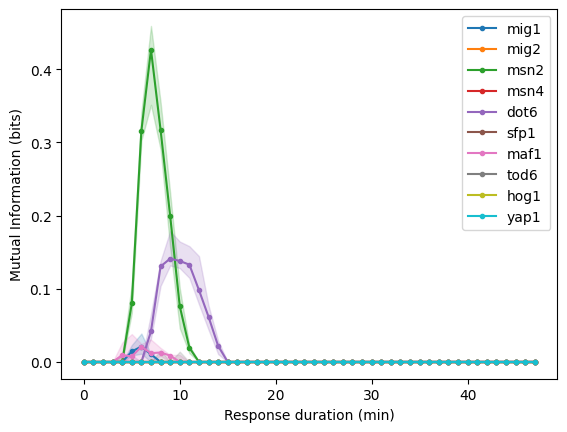

In [5]:
# Load data and define parameters
fname = "./DS_10283_2901/fig2_stress_type_expts.json"
transcription_factors = ["mig1", "mig2", "msn2", "msn4", "dot6", "sfp1", "maf1", "tod6", "hog1", "yap1"]
stress = "gluc"

with open(fname, "r") as f:
    expts = json.load(f)

# Loop through each transcription factor and find optimal LSTM parameters
for transcription_factor in transcription_factors:
    print(f"Processing transcription factor: {transcription_factor}")
    
    # Load data for the transcription factor
    data = np.array(expts[transcription_factor][stress]["GFP"]["nucLoc"]).astype("float")
    t = np.array(expts[transcription_factor][stress]["general"]["times"]).astype("float")
    b_data = data[:, t[0, :] < 0]
    a_data = data[:, t[0, :] >= 0]
    minlen = np.min([b_data.shape[1], a_data.shape[1]])
    b_data = b_data[:, -minlen:]
    a_data = a_data[:, :minlen]

    # Fill NaN by IterativeImputer
    imp_mean = IterativeImputer(random_state=0)
    a_data = imp_mean.fit_transform(a_data)
    b_data = imp_mean.fit_transform(b_data)

    # Prepare data for LSTM
    X = np.concatenate((b_data, a_data), axis=1).T  # Transpose for (samples, timesteps) shape
    y = np.array([0] * b_data.shape[1] + [1] * a_data.shape[1])

    # Time the MI estimation
    start_time = time.time()
    res = LSTM_estimate_MI([b_data, a_data], model = lstm_model, n_bootstraps=10, verbose=True)
    end_time = time.time()
    estimation_time = end_time - start_time
    print(f"Time taken to estimate MI for {transcription_factor}: {estimation_time:.2f} seconds")
    
    # Plot MI result for each transcription factor
    plot_MI(res, label=transcription_factor, color=plt.cm.tab10(transcription_factors.index(transcription_factor) % 10))

# Customize plot
plt.xlabel("Response duration (min)")
plt.ylabel("Mutual Information (bits)")
plt.legend(loc="best")
plt.show(block=False)

## Then try to train a model using all time series data

## 1. Data preparation

In [4]:
# Load data and define parameters
fname = "./DS_10283_2901/fig2_stress_type_expts.json"
transcription_factors = ["mig1", "mig2", "msn2", "msn4", "dot6", "sfp1", "maf1", "tod6", "hog1", "yap1"]
stress = "gluc"
transcription_factor="mig1"
with open(fname, "r") as f:
    expts = json.load(f)


data = np.array(expts[transcription_factor][stress]["GFP"]["nucLoc"]).astype("float")
t = np.array(expts[transcription_factor][stress]["general"]["times"]).astype("float")
data.shape, t.shape

((199, 97), (199, 97))

Visualise each TF one by one

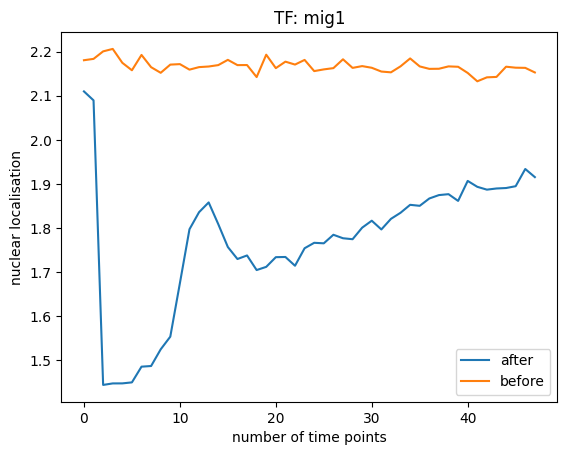

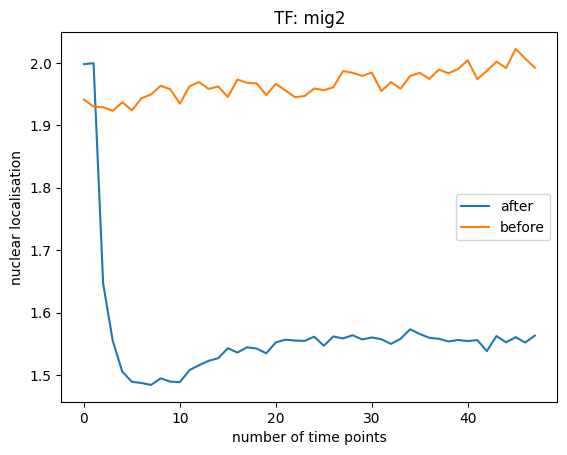

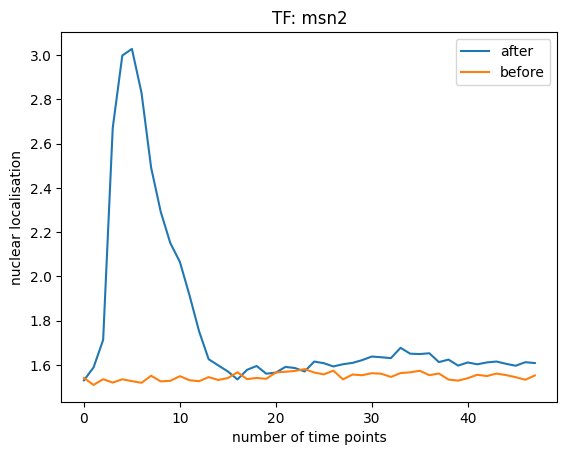

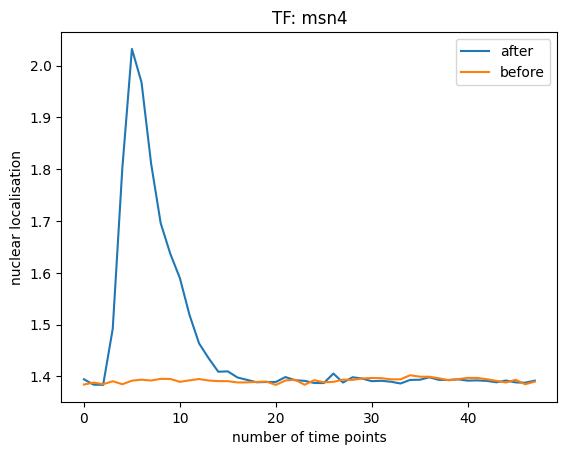

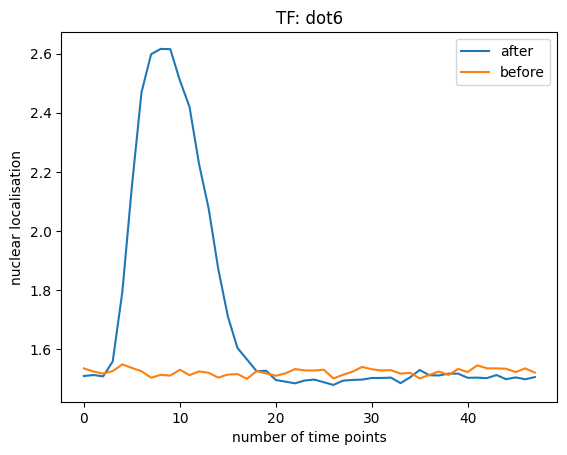

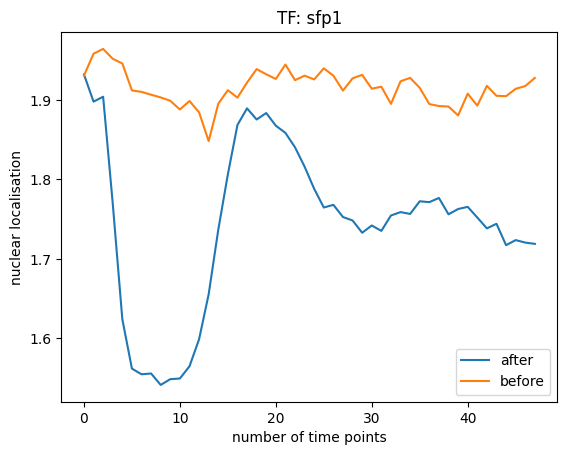

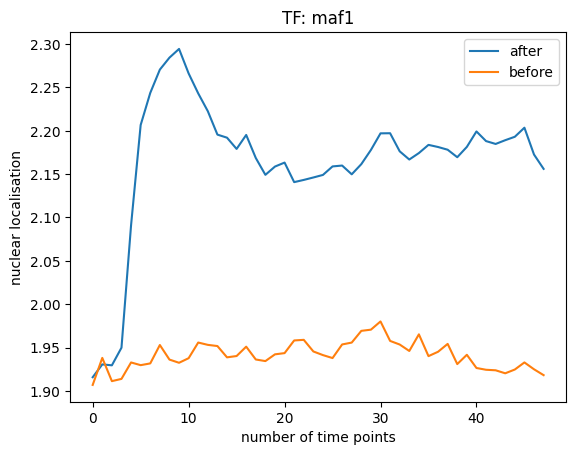

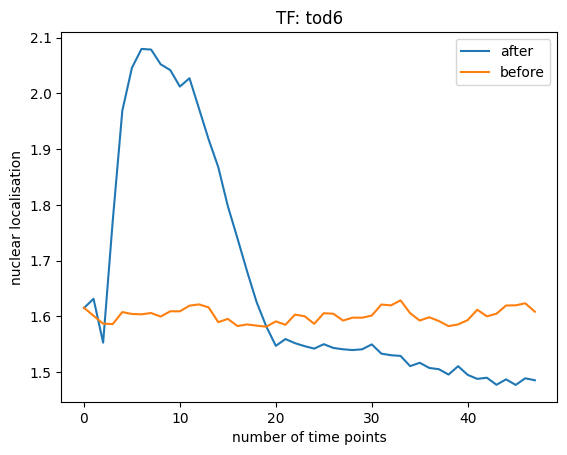

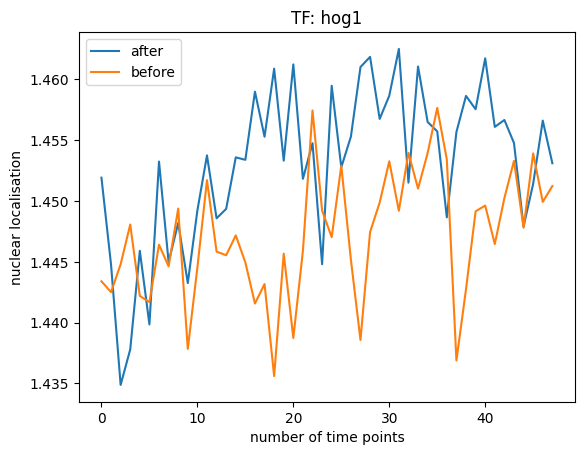

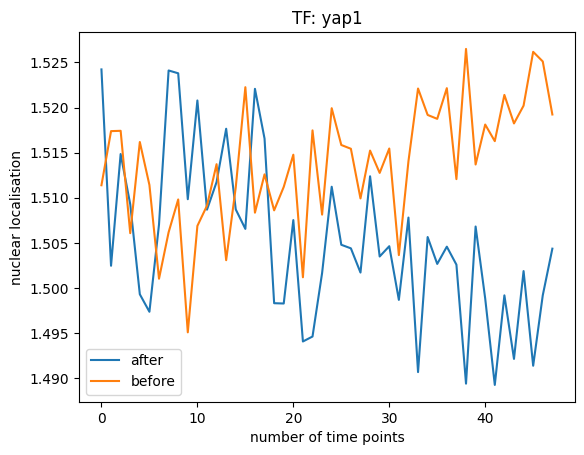

In [6]:
# Load data and define parameters
fname = "./DS_10283_2901/fig2_stress_type_expts.json"
transcription_factors = ["mig1", "mig2", "msn2", "msn4", "dot6", "sfp1", "maf1", "tod6", "hog1", "yap1"]
stress = "gluc"

with open(fname, "r") as f:
    expts = json.load(f)

a_data_all = []
b_data_all = []
max_len = 0

# Prepare training data for an example transcription factor
for transcription_factor in transcription_factors:
    data = np.array(expts[transcription_factor][stress]["GFP"]["nucLoc"]).astype("float")
    t = np.array(expts[transcription_factor][stress]["general"]["times"]).astype("float")
    b_data = data[:, t[0, :] < 0]
    a_data = data[:, t[0, :] >= 0]
    minlen = np.min([b_data.shape[1], a_data.shape[1]])
    b_data = b_data[:, -minlen:]
    a_data = a_data[:, :minlen]

    # Fill NaN using IterativeImputer
    imp_mean = IterativeImputer(random_state=0)
    a_data = imp_mean.fit_transform(a_data)
    b_data = imp_mean.fit_transform(b_data)

    a_data_all.append(a_data)
    b_data_all.append(b_data)

    # plot the data
    plt.figure()
    plt.plot(np.mean(a_data, axis=0), label="after")
    plt.plot(np.mean(b_data, axis=0), label="before")
    plt.xlabel("number of time points")
    plt.ylabel("nuclear localisation")
    plt.title(f"TF: {transcription_factor}")
    plt.legend()
    plt.show(block=False)

    max_len = max(max_len, a_data.shape[0], b_data.shape[0])

# Pad arrays to the same length
a_data_all = [np.pad(a, ((0, max_len - a.shape[0]), (0, 0)), 'constant') for a in a_data_all]
b_data_all = [np.pad(b, ((0, max_len - b.shape[0]), (0, 0)), 'constant') for b in b_data_all]

a_data_all = np.concatenate(a_data_all, axis=1)
b_data_all = np.concatenate(b_data_all, axis=1)

Plot everything on the same figure

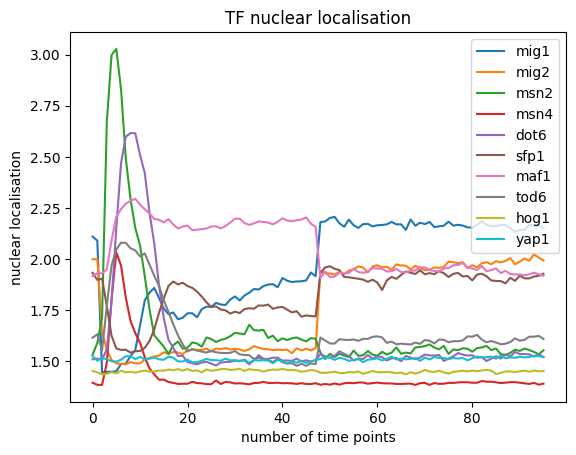

In [10]:
# Load data and define parameters
fname = "./DS_10283_2901/fig2_stress_type_expts.json"
transcription_factors = ["mig1", "mig2", "msn2", "msn4", "dot6", "sfp1", "maf1", "tod6", "hog1", "yap1"]
stress = "gluc"

with open(fname, "r") as f:
    expts = json.load(f)

a_data_all = []
b_data_all = []
max_len = 0

# plot the data
plt.figure()
# Prepare training data for an example transcription factor
for transcription_factor in transcription_factors:
    data = np.array(expts[transcription_factor][stress]["GFP"]["nucLoc"]).astype("float")
    t = np.array(expts[transcription_factor][stress]["general"]["times"]).astype("float")
    b_data = data[:, t[0, :] < 0]
    a_data = data[:, t[0, :] >= 0]
    minlen = np.min([b_data.shape[1], a_data.shape[1]])
    b_data = b_data[:, -minlen:]
    a_data = a_data[:, :minlen]

    # Fill NaN using IterativeImputer
    imp_mean = IterativeImputer(random_state=0)
    a_data = imp_mean.fit_transform(a_data)
    b_data = imp_mean.fit_transform(b_data)

    a_data_all.append(a_data)
    b_data_all.append(b_data)

    data_all = np.concatenate([a_data, b_data], axis=1)

    # plt.plot(np.mean(a_data, axis=0), label=f"{transcription_factor}_after")
    # plt.plot(np.mean(b_data, axis=0), label=f"{transcription_factor}_before")
    plt.plot(np.mean(data_all, axis=0), label=f"{transcription_factor}")
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.xlabel("number of time points")
    plt.ylabel("nuclear localisation")
    plt.title(f"TF nuclear localisation")
    plt.legend()
    
    max_len = max(max_len, a_data.shape[0], b_data.shape[0])

plt.show(block=False)

# Pad arrays to the same length
a_data_all = [np.pad(a, ((0, max_len - a.shape[0]), (0, 0)), 'constant') for a in a_data_all]
b_data_all = [np.pad(b, ((0, max_len - b.shape[0]), (0, 0)), 'constant') for b in b_data_all]

a_data_all = np.concatenate(a_data_all, axis=1)
b_data_all = np.concatenate(b_data_all, axis=1)

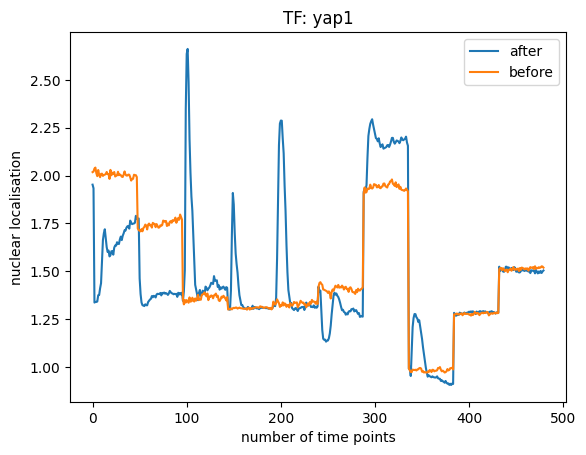

In [9]:
# plot the data
# plt.figure()
# plt.plot(, color="r", alpha=0.5)
# plt.plot(, color="b", alpha=0.5)
# plt.xlabel("Time (min)")
# plt.ylabel("GFP intensity")
# plt.title("GFP intensity over time")
# plt.show()

plt.figure()
plt.plot(np.mean(a_data_all, axis=0), label="after")
plt.plot(np.mean(b_data_all, axis=0), label="before")
plt.xlabel("number of time points")
plt.ylabel("nuclear localisation")
plt.title(f"TF: {transcription_factor}")
plt.legend()
plt.show(block=False)


In [23]:
import numpy as np
import json
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
import time

# Load data and define parameters
fname = "./DS_10283_2901/fig2_stress_type_expts.json"
transcription_factors = ["mig1", "mig2", "msn2", "msn4", "dot6", "sfp1", "maf1", "tod6", "hog1", "yap1"]
stress = "gluc"

with open(fname, "r") as f:
    expts = json.load(f)

a_data_all = []
b_data_all = []
max_len = 0

# Prepare training data for an example transcription factor
for transcription_factor in transcription_factors:
    data = np.array(expts[transcription_factor][stress]["GFP"]["nucLoc"]).astype("float")
    t = np.array(expts[transcription_factor][stress]["general"]["times"]).astype("float")
    b_data = data[:, t[0, :] < 0]
    a_data = data[:, t[0, :] >= 0]
    minlen = np.min([b_data.shape[1], a_data.shape[1]])
    b_data = b_data[:, -minlen:]
    a_data = a_data[:, :minlen]

    # Fill NaN using IterativeImputer
    imp_mean = IterativeImputer(random_state=0)
    a_data = imp_mean.fit_transform(a_data)
    b_data = imp_mean.fit_transform(b_data)

    a_data_all.append(a_data)
    b_data_all.append(b_data)
    max_len = max(max_len, a_data.shape[0], b_data.shape[0])

# Pad arrays to the same length
a_data_all = [np.pad(a, ((0, max_len - a.shape[0]), (0, 0)), 'constant') for a in a_data_all]
b_data_all = [np.pad(b, ((0, max_len - b.shape[0]), (0, 0)), 'constant') for b in b_data_all]

a_data_all = np.concatenate(a_data_all, axis=1)
b_data_all = np.concatenate(b_data_all, axis=1)
# Prepare data for LSTM
X = np.concatenate((b_data_all, a_data_all), axis=1).T # Shape (samples, timesteps)  
y = np.array([0] * b_data_all.shape[1] + [1] * a_data_all.shape[1])

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X.reshape(X.shape[0], X.shape[1], 1), y, test_size=0.25)

# Define and compile the LSTM model
def create_lstm_model(input_shape):
    model = Sequential([
        Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        LSTM(100, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, 1)),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    return model

# Initialize and train the LSTM model
lstm_model = create_lstm_model(input_shape=(X_train.shape[1], 1))
lstm_model.fit(X_train, y_train, epochs=30, batch_size=1, validation_split=0.2)

# Evaluate the model
accuracy = lstm_model.evaluate(X_test, y_test, verbose=0)[1]
print(f"Test accuracy: {accuracy:.2f}")

# Save the model
lstm_model.save("lstm_model.keras")


Epoch 1/30
576/576 [==============================] - 60s 101ms/step - loss: 0.7023 - accuracy: 0.4531 - val_loss: 0.6931 - val_accuracy: 0.4792
Epoch 2/30
576/576 [==============================] - 57s 99ms/step - loss: 0.6954 - accuracy: 0.5174 - val_loss: 0.6957 - val_accuracy: 0.4792
Epoch 3/30
576/576 [==============================] - 57s 99ms/step - loss: 0.6962 - accuracy: 0.4861 - val_loss: 0.6949 - val_accuracy: 0.4792
Epoch 4/30
576/576 [==============================] - 57s 100ms/step - loss: 0.6954 - accuracy: 0.4601 - val_loss: 0.6943 - val_accuracy: 0.4792
Epoch 5/30
576/576 [==============================] - 58s 101ms/step - loss: 0.6958 - accuracy: 0.4913 - val_loss: 0.6940 - val_accuracy: 0.4792
Epoch 6/30
576/576 [==============================] - 57s 100ms/step - loss: 0.6943 - accuracy: 0.4965 - val_loss: 0.6916 - val_accuracy: 0.4931
Epoch 7/30
576/576 [==============================] - 58s 101ms/step - loss: 0.6947 - accuracy: 0.4705 - val_loss: 0.6936 - val_accu

Processing transcription factor: mig1
duration of time series is 1
4/4 [==============================] - 0s 19ms/step
median MI= 0.00 [0.00, 0.00]
duration of time series is 2
4/4 [==============================] - 0s 17ms/step
median MI= 0.00 [0.00, 0.00]
duration of time series is 3
4/4 [==============================] - 0s 17ms/step
median MI= 0.00 [0.00, 0.00]
duration of time series is 4
4/4 [==============================] - 0s 18ms/step
median MI= 0.00 [0.00, 0.00]
duration of time series is 5
4/4 [==============================] - 0s 17ms/step
median MI= 0.00 [0.00, 0.00]
duration of time series is 6
4/4 [==============================] - 0s 18ms/step
median MI= 0.00 [0.00, 0.00]
duration of time series is 7
4/4 [==============================] - 0s 18ms/step
median MI= 0.00 [0.00, 0.00]
duration of time series is 8
4/4 [==============================] - 0s 18ms/step
median MI= 0.00 [0.00, 0.00]
duration of time series is 9
4/4 [==============================] - 0s 18ms/step
m

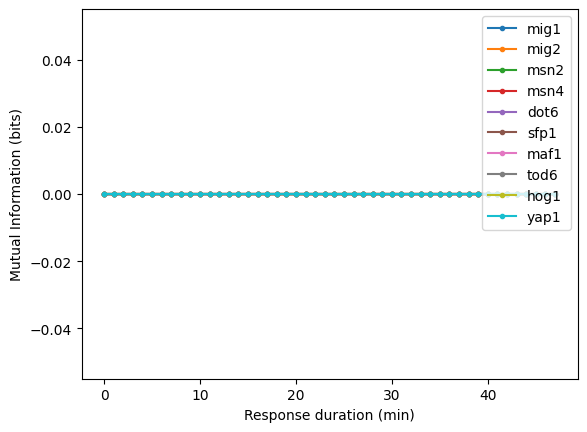

In [25]:
# Load data and define parameters
fname = "./DS_10283_2901/fig2_stress_type_expts.json"
transcription_factors = ["mig1", "mig2", "msn2", "msn4", "dot6", "sfp1", "maf1", "tod6", "hog1", "yap1"]
stress = "gluc"

with open(fname, "r") as f:
    expts = json.load(f)

# Loop through each transcription factor and find optimal LSTM parameters
for transcription_factor in transcription_factors:
    print(f"Processing transcription factor: {transcription_factor}")
    
    # Load data for the transcription factor
    data = np.array(expts[transcription_factor][stress]["GFP"]["nucLoc"]).astype("float")
    t = np.array(expts[transcription_factor][stress]["general"]["times"]).astype("float")
    b_data = data[:, t[0, :] < 0]
    a_data = data[:, t[0, :] >= 0]
    minlen = np.min([b_data.shape[1], a_data.shape[1]])
    b_data = b_data[:, -minlen:]
    a_data = a_data[:, :minlen]

    # Fill NaN by IterativeImputer
    imp_mean = IterativeImputer(random_state=0)
    a_data = imp_mean.fit_transform(a_data)
    b_data = imp_mean.fit_transform(b_data)

    # Prepare data for LSTM
    X = np.concatenate((b_data, a_data), axis=1).T  # Transpose for (samples, timesteps) shape
    y = np.array([0] * b_data.shape[1] + [1] * a_data.shape[1])

    # Time the MI estimation
    start_time = time.time()
    res = LSTM_estimate_MI([b_data, a_data], model = lstm_model, n_bootstraps=10, verbose=True)
    end_time = time.time()
    estimation_time = end_time - start_time
    print(f"Time taken to estimate MI for {transcription_factor}: {estimation_time:.2f} seconds")
    
    # Plot MI result for each transcription factor
    plot_MI(res, label=transcription_factor, color=plt.cm.tab10(transcription_factors.index(transcription_factor) % 10))

# Customize plot
plt.xlabel("Response duration (min)")
plt.ylabel("Mutual Information (bits)")
plt.legend(loc="best")
plt.show(block=False)

# Change to using pytorch instead

In [ ]:
import torch
import torch.nn as nn

# Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM Layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout_rate,
            batch_first=True
        )

        # Fully Connected Layers
        self.fc1 = nn.Linear(hidden_size, 50)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(50, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # LSTM output
        lstm_out, _ = self.lstm(x)
        # Use the output from the last time step
        lstm_out = lstm_out[:, -1, :]
        # Fully connected layers
        x = self.fc1(lstm_out)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Hyperparameters
input_size = 1  # Number of input features
hidden_size = 100  # Number of LSTM units
num_layers = 2  # Number of LSTM layers
dropout_rate = 0.3
output_size = 1  # Binary classification output

# Create the model
model = LSTMModel(input_size, hidden_size, num_layers, dropout_rate, output_size)

# Define the loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
